In [38]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams.update({'font.size': 12})
SaveFigs = False

from scipy import signal 
from scipy import stats
import itertools
import seaborn as sns
import statsmodels.api as sm
import random

In [39]:
import json
json_open = open('../../dj_local_conf.json', 'r') 
config = json.load(json_open)

import datajoint as dj
dj.config['database.host'] = config["database.host"]
dj.config['database.user'] = config ["database.user"]
dj.config['database.password'] = config["database.password"]
dj.conn().connect()

from pipeline import lab, get_schema_name, experiment, foraging_model, ephys, foraging_analysis, histology, ccf
from pipeline.plot import unit_psth
from pipeline.plot.foraging_model_plot import plot_session_model_comparison, plot_session_fitted_choice
from pipeline import psth_foraging
from pipeline import util
from pipeline.model import bandit_model

In [40]:
def gen_random_walk_neuron(n_trial, diff_para=0.1, f_1=2.5, 
                           seed=None, plot=False):
    if seed:
        np.random.seed(seed)

    firing_rate = np.zeros(n_trial)
    firing_rate[0] = np.random.uniform(f_1-0.1, f_1+0.1)
    for i in range(1, n_trial):
        firing_rate[i] = max((0, firing_rate[i-1]+np.random.normal(loc=0, scale=diff_para, size=1)))
    
    if plot:
        plt.plot(firing_rate)

    return firing_rate


def gen_action_value_neuron(qs, k_max_modulation=2.35, f_baseline=2.5, 
                            seed=None, plot=False):
    if seed:
        np.random.seed(seed)
    
    r_neuron_modulation = np.random.uniform(low=-1.0, high=1.0, size=1)
    firing_rate = f_baseline + k_max_modulation * r_neuron_modulation * qs
    spike_cts = np.random.poisson(lam=firing_rate)
    
    if plot:
        plt.plot(spike_cts)

    return spike_cts

In [41]:
subject_id = 482353
model_id = 10
q_latent_variable = (foraging_model.FittedSessionModel.TrialLatentVariable 
                    & {'subject_id': subject_id, 
                       'model_id': model_id})

df_Q = pd.DataFrame(q_latent_variable.fetch())
df_Q_left = df_Q[df_Q['water_port']=='left']#.sort_values(by=['trial'])
df_Q_right = df_Q[df_Q['water_port']=='right']#.sort_values(by=['trial'])

# get only Qs columns
df_Q_right = df_Q_right[['session', 'trial', 'action_value']].rename(columns={'action_value': 'Q_right'})#.reset_index(drop=True)
df_Q_left = df_Q_left[['session', 'trial', 'action_value']].rename(columns={'action_value': 'Q_left'})#.reset_index(drop=True)
df_Qs = df_Q_left.merge(df_Q_right)

In [42]:
# select sessions
sessions_all = np.unique(df_Qs['session'].values)
print(f'total sessions: {len(sessions_all)}, {sessions_all}')

n_session_to_ana = 5
manual_selection = True
if manual_selection:
    sessions = [38, 39, 40, 42, 45]
else:
    sessions = np.random.choice(sessions_all, size=n_session_to_ana)
print(f'selected sessions for ana: {sessions}')

# get min session length
session_len = []
for session in sessions:
    df_Qs_session = df_Qs[df_Qs['session']==session].sort_values(by=['trial'])
    session_len.append(len(df_Qs_session))

print(f'min session {session_len.index(min(session_len))} len: {min(session_len)}, max session {session_len.index(max(session_len))} len: {max(session_len)}')
len_min = min(session_len)

total sessions: 45, [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45]
selected sessions for ana: [38, 39, 40, 42, 45]
min session 0 len: 468, max session 3 len: 1143


### generate session action-reward sequence

In [ ]:
key = {'subject_id': 482353, 'session': 38, 'model_id': 10}

In [89]:
# get session history

# get more exp session info by
# dj.ERD(experiment)

block_reward_prob = pd.DataFrame((experiment.SessionBlock.WaterPortRewardProbability() & key).fetch())
blocks = np.unique(block_reward_prob['block'].values)
if np.max(blocks) != len(blocks):
    raise ValueError('missing blocks!')
else:
    n_blocks = len(blocks)

trial_reward_availability = pd.DataFrame((experiment.TrialAvailableReward() & key ).fetch())

block_lengths, _ = np.histogram((experiment.SessionBlock.BlockTrial & key).fetch('block'), bins=np.arange(1, n_blocks+1))
print(f'check sum of block len: {np.sum(block_lengths)} vs total trials {len(trial_reward_availability)/2}')

# if needed
# choice_outcome_sequence = pd.DataFrame((experiment.WaterPortChoice.proj(choice='water_port') * experiment.BehaviorTrial.proj('outcome', 'early_lick') & key).fetch())
# experiment.BehaviorTrial() & 'subject_id=482353' & 'session=38'

choice_history, reward_history, _, p_reward, q_choice_outcome = foraging_model.get_session_history(key, remove_ignored=False)

block_length_avg = np.average(block_lengths)
block_length_std = np.std(block_lengths)
print(f'block length: avg - {block_length_avg}, std - {block_length_std}')

check sum of block len: 574 vs total trials 574.0


In [132]:
# get fitted model

# get more fitted model info
# dj.ERD(foraging_model)
# dj.ERD(foraging_model.FittedSessionModel) + 1
# foraging_model.Model() * foraging_model.Model.Param() & 'model_id=10'
# (foraging_model.FittedSessionModel.key_source & 'model_id=10' & 'subject_id=482353' & 'session=38').fetch('fit_cmd')
# foraging_model.Model() * foraging_model.Model.Param() & 'model_id=10'
# foraging_model.ModelClass()


model_para = pd.DataFrame((foraging_model.FittedSessionModel.Param & key).fetch())
model_para_dict = {}
for i in range(len(model_para)):
    model_para_dict[model_para.iloc[i]['model_param']] = model_para.iloc[i]['fitted_value']
    
forager = bandit_model.BanditModel(forager='LNP_softmax', n_trials=int(len(trial_reward_availability)/2), 
                                   **model_para_dict)
for k, v in vars(forager).items():
    if v is not None:
        print(f'{k}: {v}')

forager: LNP_softmax
if_baited: True
softmax_temperature: 0.188097
loss_count_threshold_std: 0
p_reward_seed_override: 
p_reward_sum: 0.45
if_fit_mode: False
K: 2
n_trials: 574
bias_terms: [-0.0129319  0.       ]
taus: [2.67017]
w_taus: [1]


In [133]:
forager.generate_p_reward(block_length_avg, block_length_std)
for k, v in vars(forager).items():
    if v is not None:
        print(f'{k}: {v}')

forager: LNP_softmax
if_baited: True
softmax_temperature: 0.188097
loss_count_threshold_std: 0
p_reward_seed_override: 
p_reward_sum: 0.45
if_fit_mode: False
K: 2
n_trials: 574
bias_terms: [-0.0129319  0.       ]
taus: [2.67017]
w_taus: [1]
n_blocks: 10
p_reward: [[0.0643 0.0643 0.0643 ... 0.3857 0.3857 0.3857]
 [0.3857 0.3857 0.3857 ... 0.0643 0.0643 0.0643]]
block_size: [68 72 47 50 79 45 55 82 49 28]
p_reward_fraction: [0.85711111 0.85711111 0.85711111 0.85711111 0.85711111 0.85711111
 0.85711111 0.85711111 0.85711111 0.85711111 0.85711111 0.85711111
 0.85711111 0.85711111 0.85711111 0.85711111 0.85711111 0.85711111
 0.85711111 0.85711111 0.85711111 0.85711111 0.85711111 0.85711111
 0.85711111 0.85711111 0.85711111 0.85711111 0.85711111 0.85711111
 0.85711111 0.85711111 0.85711111 0.85711111 0.85711111 0.85711111
 0.85711111 0.85711111 0.85711111 0.85711111 0.85711111 0.85711111
 0.85711111 0.85711111 0.85711111 0.85711111 0.85711111 0.85711111
 0.85711111 0.85711111 0.85711111 0.85

forager: LNP_softmax
if_baited: True
softmax_temperature: 0.188097
loss_count_threshold_std: 0
p_reward_seed_override: 
p_reward_sum: 0.45
if_fit_mode: False
K: 2
n_trials: 574
bias_terms: [-0.0129319  0.       ]
taus: [2.67017]
w_taus: [1]
n_blocks: 9
p_reward: [[0.225 0.225 0.225 ... 0.225 0.225 0.225]
 [0.225 0.225 0.225 ... 0.225 0.225 0.225]]
block_size: [ 55  48  58  79  75  96 101  58   5]
p_reward_fraction: [0.5        0.5        0.5        0.5        0.5        0.5
 0.5        0.5        0.5        0.5        0.5        0.5
 0.5        0.5        0.5        0.5        0.5        0.5
 0.5        0.5        0.5        0.5        0.5        0.5
 0.5        0.5        0.5        0.5        0.5        0.5
 0.5        0.5        0.5        0.5        0.5        0.5
 0.5        0.5        0.5        0.5        0.5        0.5
 0.5        0.5        0.5        0.5        0.5        0.5
 0.5        0.5        0.5        0.5        0.5        0.5
 0.5        0.14288889 0.14288889 0.14288

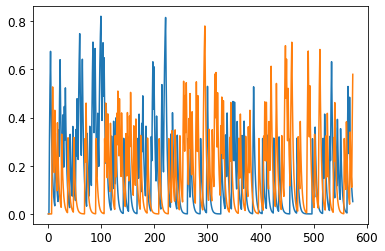

In [135]:
forager.simulate()
for k, v in vars(forager).items():
    if v is not None:
        print(f'{k}: {v}')

plt.plot(forager.q_estimation[0])
plt.plot(forager.q_estimation[1])

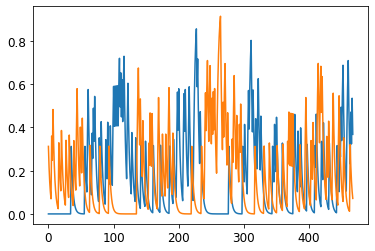

In [139]:
q_latent_variable = (foraging_model.FittedSessionModel.TrialLatentVariable & key)

df_Q = pd.DataFrame(q_latent_variable.fetch())
df_Q_left = df_Q[df_Q['water_port']=='left']#.sort_values(by=['trial'])
df_Q_right = df_Q[df_Q['water_port']=='right']#.sort_values(by=['trial'])

# get only Qs columns
df_Q_right = df_Q_right[['session', 'trial', 'action_value']].rename(columns={'action_value': 'Q_right'})#.reset_index(drop=True)
df_Q_left = df_Q_left[['session', 'trial', 'action_value']].rename(columns={'action_value': 'Q_left'})#.reset_index(drop=True)
df_Qs = df_Q_left.merge(df_Q_right)

plt.plot(df_Qs[df_Qs['session']==key['session']]['Q_left'].values)
plt.plot(df_Qs[df_Qs['session']==key['session']]['Q_right'].values)